In [1]:
# Setting up the working atmosphere
import numpy as np
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import re
from collections import defaultdict
import spacy
import logging 
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
import pandas as pd
df = pd.read_csv('../input/covid19-vaccine-news-reddit-discussions/comments.csv')

In [2]:
df.head()

,post_id,post_author,post_date,post_title,post_score,post_permalink,post_url,comment_id,comment_author,comment_date,comment_parent_id,comment_edited,comment_score,comment_body
0,kdmkbz,KinnerNevada,2020-12-15 14:21:20,"Moderna's vaccine is highly effective, FDA say...",42481,/r/Coronavirus/comments/kdmkbz/modernas_vaccin...,https://www.nbcnews.com/health/health-news/mod...,gfx8br4,AutoModerator,2020-12-15 14:21:21,t3_kdmkbz,False,1,"This post appears to be about vaccines, please..."
1,kdmkbz,KinnerNevada,2020-12-15 14:21:20,"Moderna's vaccine is highly effective, FDA say...",42481,/r/Coronavirus/comments/kdmkbz/modernas_vaccin...,https://www.nbcnews.com/health/health-news/mod...,gfx930g,Hothabanero6,2020-12-15 14:28:43,t3_kdmkbz,False,1784,Who's ahead in the pool for the third vaccine ...
2,kdmkbz,KinnerNevada,2020-12-15 14:21:20,"Moderna's vaccine is highly effective, FDA say...",42481,/r/Coronavirus/comments/kdmkbz/modernas_vaccin...,https://www.nbcnews.com/health/health-news/mod...,gfxaiv8,jsinkwitz,2020-12-15 14:42:16,t3_kdmkbz,False,1905,"""asymptomatic infection was reduced by 63 perc..."
3,kdmkbz,KinnerNevada,2020-12-15 14:21:20,"Moderna's vaccine is highly effective, FDA say...",42481,/r/Coronavirus/comments/kdmkbz/modernas_vaccin...,https://www.nbcnews.com/health/health-news/mod...,gfxglf1,TheyreGoodDogsBrent,2020-12-15 15:36:09,t3_kdmkbz,False,3503,> and appears to prevent the spread of the vir...
4,kdmkbz,KinnerNevada,2020-12-15 14:21:20,"Moderna's vaccine is highly effective, FDA say...",42481,/r/Coronavirus/comments/kdmkbz/modernas_vaccin...,https://www.nbcnews.com/health/health-news/mod...,gfxr0fa,BG1234567,2020-12-15 17:01:14,t3_kdmkbz,False,326,The fact that there are multiple companies mak...


In [3]:
df.isnull().sum() #Check if there is na values

post_id              0
post_author          0
post_date            0
post_title           0
post_score           0
post_permalink       0
post_url             0
comment_id           0
comment_author       0
comment_date         0
comment_parent_id    0
comment_edited       0
comment_score        0
comment_body         0
dtype: int64

In [4]:
df.shape

(34768, 14)

In [5]:
# Part 1.1
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 

In [6]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

In [7]:
clean = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['comment_body']) #Remove non-alphabetic characters

In [8]:
txt = [cleaning(doc) for doc in nlp.pipe(clean, batch_size=5000)]

In [9]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(29384, 1)

In [10]:
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df_clean['clean']]

In [11]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [12]:
bigram = Phraser(phrases)
sentences = bigram[sent]

In [13]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

19644

In [14]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['vaccine',
 'people',
 's',
 'get',
 'covid',
 'like',
 'think',
 'know',
 'go',
 'time']

In [15]:
import multiprocessing

In [16]:
cores = multiprocessing.cpu_count()

In [17]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [18]:
w2v_model.build_vocab(sentences, progress_per=10000)

In [19]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(6109873, 15641280)

In [20]:
a = w2v_model.wv.most_similar(positive=["vaccine"],topn=5) # 5 similar words for vaccine
print(a)

[('moderna', 0.5215964317321777), ('pfizer_biontech', 0.5052772164344788), ('candidate', 0.4996466636657715), ('mrna', 0.4945363402366638), ('afaik', 0.4909786283969879)]


In [21]:
b = w2v_model.wv.most_similar(positive=["sad"],topn=5) # 5 similar words for sad
print(b)

[('angry', 0.7483792304992676), ('sorry', 0.7418261170387268), ('doom', 0.7168172597885132), ('funny', 0.7094622254371643), ('bro', 0.702629804611206)]


In [22]:
# Part 1.2 t-SNE visulaisation
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [23]:
w2v_model.wv['vaccine']

array([-0.21271276,  0.2551675 , -0.20798542,  0.22218095,  0.12775686,
        0.07027594,  0.19652945,  0.50931615, -0.11224749, -0.05917441,
        0.2112513 ,  0.04297606,  0.03271793,  0.13539968, -0.0604631 ,
       -0.14981619,  0.07694408,  0.32087067, -0.47120312, -0.03360106,
       -0.01022292, -0.19188744,  0.12259824, -0.29286098,  0.6883925 ,
       -0.27872872, -0.20717137,  0.14261067, -0.18303771, -0.08488584,
       -0.2082536 ,  0.04901834,  0.07827869,  0.00290445, -0.3830108 ,
        0.08498299,  0.02429198, -0.2935044 , -0.06453378, -0.14453617,
       -0.3171224 , -0.16379686,  0.11428972, -0.18382418,  0.27943856,
        0.11251439, -0.04044595,  0.25277475, -0.28938624,  0.06698909,
       -0.08061777,  0.16565636,  0.14077213, -0.39996716, -0.1630513 ,
        0.00287927, -0.04416066, -0.07872316, -0.21418747,  0.15779571,
       -0.07967526,  0.0335771 ,  0.07865002, -0.1432585 , -0.10686259,
       -0.02039482, -0.23869474,  0.28167117, -0.12471757,  0.06

In [24]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.key_to_index:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=20, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


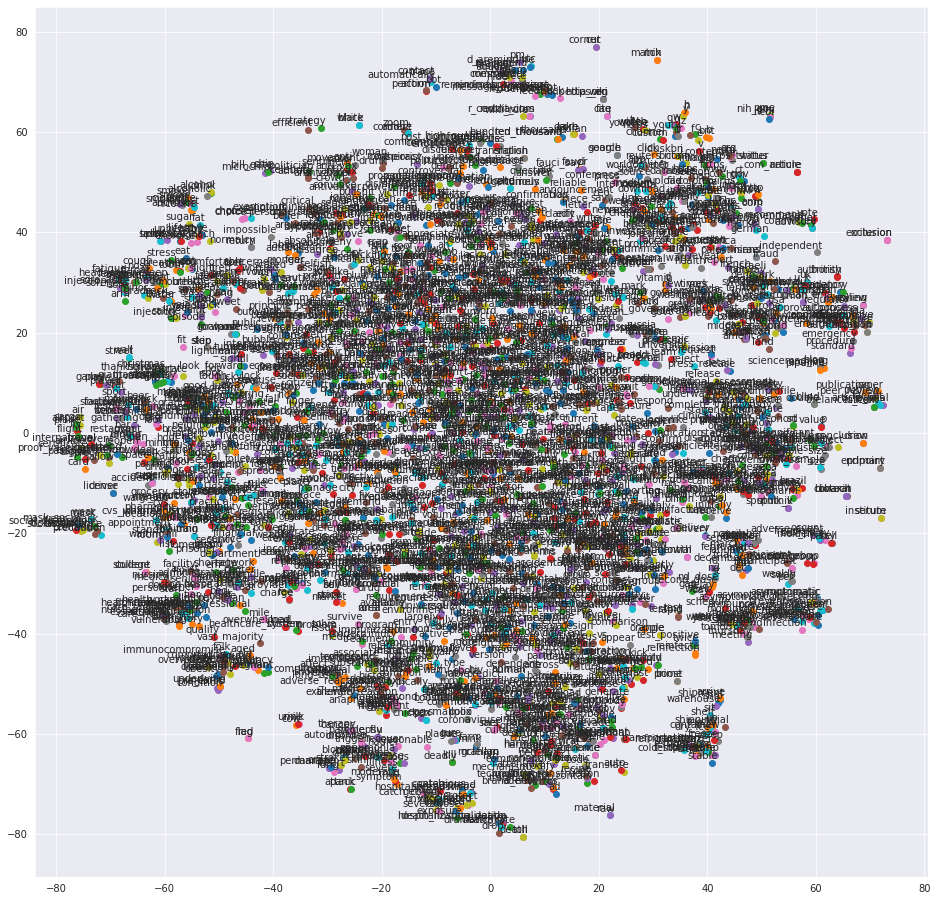

In [25]:
tsne_plot(w2v_model)

In [26]:
# It was quite messy so I decided to write another tsne plot() and only choose top 50 relevant words for both words uses in part 1.1 (Vaccine and Sad)
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=21).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


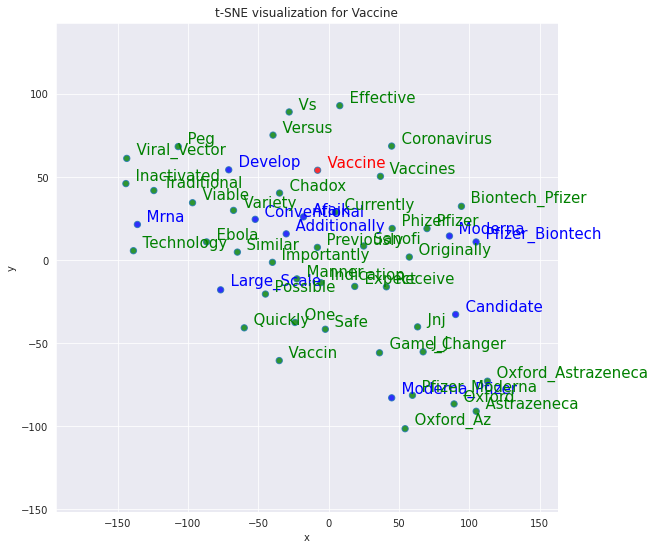

In [27]:
tsnescatterplot(w2v_model, 'vaccine',[t[0] for t in w2v_model.wv.most_similar(positive=["vaccine"], topn=50)][10:])

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


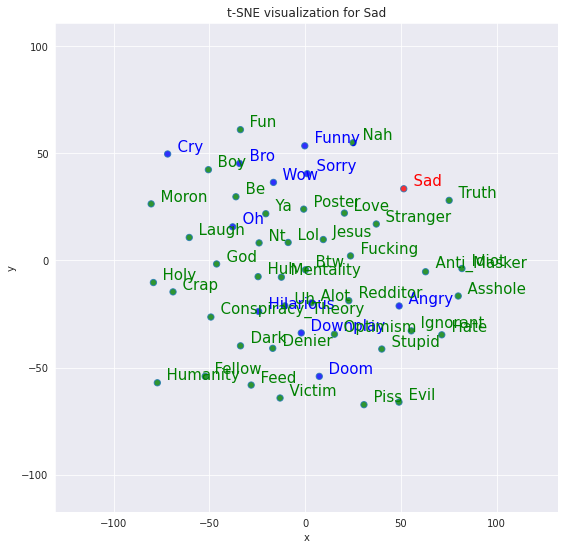

In [28]:
tsnescatterplot(w2v_model, 'sad',[t[0] for t in w2v_model.wv.most_similar(positive=["sad"], topn=50)][10:])